In [16]:
!pip install torch_geometric

In [17]:
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATv2Conv
import numpy as np
import networkx as nx
from sklearn.decomposition import PCA


In [18]:
import torch
from torch_geometric.datasets import Coauthor
import torch_geometric.transforms as T

# --- Load dataset ---
dataset = Coauthor(root="data/", name="CS", transform=T.NormalizeFeatures())

# The dataset contains only 1 graph object
data = dataset[0]

print("=== Coauthor Cora Dataset ===")
print(f"Number of nodes: {data.num_nodes}")
print(f"Number of edges: {data.num_edges}")
print(f"Number of node features: {data.num_features}")
print(f"Number of classes: {dataset.num_classes}")

# Check if masks exist (they do NOT exist, this dataset is not for semi-supervised learning)
print("\nDoes it have train/val/test masks?",
      hasattr(data, "train_mask") and data.train_mask is not None)

# You will need to create masks manually
print("\nGraph properties:")
print(f"Is undirected: {data.is_undirected()}")
print(f"Edge index shape: {data.edge_index.shape}")
print(f"Feature matrix shape: {data.x.shape}")
print(f"Label tensor shape: {data.y.shape}")


=== Coauthor Cora Dataset ===
Number of nodes: 18333
Number of edges: 163788
Number of node features: 6805
Number of classes: 15

Does it have train/val/test masks? False

Graph properties:
Is undirected: True
Edge index shape: torch.Size([2, 163788])
Feature matrix shape: torch.Size([18333, 6805])
Label tensor shape: torch.Size([18333])


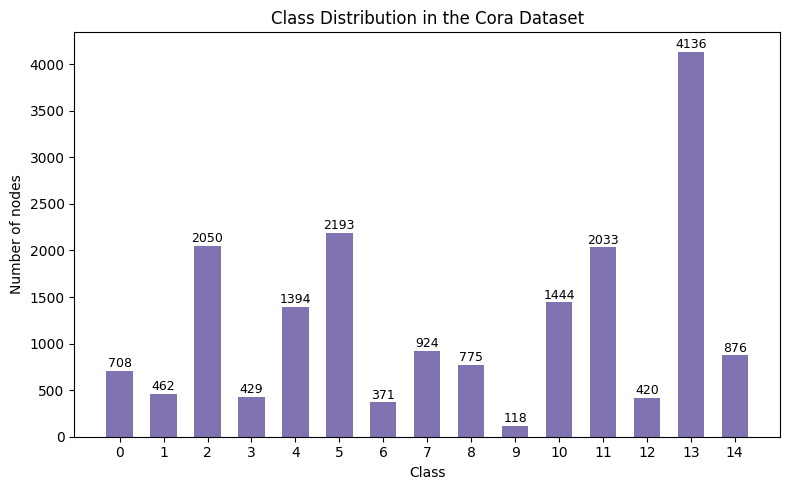

In [19]:
# --- Visualizations for Class Distribution Plot ---

labels = data.y.numpy()
num_classes = dataset.num_classes

plt.figure(figsize=(8, 5))

# Bar plot
unique, counts = np.unique(labels, return_counts=True)
plt.bar(unique, counts, width=0.6,color="#8172B2")

plt.xticks(unique)
plt.xlabel("Class")
plt.ylabel("Number of nodes")
plt.title("Class Distribution in the Cora Dataset")

# Add counts on top of each bar
for cls, count in zip(unique, counts):
    plt.text(cls, count + 5, str(count), ha="center", va="bottom", fontsize=9)

plt.tight_layout()
plt.show()


In [20]:
import plotly.graph_objects as go
from sklearn.decomposition import PCA
import numpy as np

# PCA
X = data.x.numpy()
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X)

labels = data.y.numpy()

# Try to load class names; Coauthor CS does not provide them
try:
    class_names = dataset.classes
except:
    class_names = [f"Class {i}" for i in range(dataset.num_classes)]

topics = [class_names[int(c)] for c in labels]

# Node scatter (interactive)
node_trace = go.Scatter(
    x=X_reduced[:, 0],
    y=X_reduced[:, 1],
    mode="markers",
    marker=dict(
        size=6,
        color=labels,
        colorscale="Turbo",
        showscale=True,
        colorbar=dict(title="Class ID")
    ),
    hovertemplate="<b>Node:</b> %{customdata[0]}<br>"
                  "<b>Class ID:</b> %{customdata[1]}<br>"
                  "<b>Category:</b> %{customdata[2]}<extra></extra>",
    customdata=np.stack([np.arange(len(labels)), labels, topics], axis=1)
)

fig = go.Figure(node_trace)

fig.update_layout(
    title="PCA Visualization of Node Features (Interactive)",
    xaxis_title="PCA Component 1",
    yaxis_title="PCA Component 2",
    width=900,
    height=650,
    plot_bgcolor="white"
)

fig.show()
fig.write_html("graph_pca_interactive.html")

In [21]:
import umap
import plotly.graph_objects as go
import networkx as nx
import numpy as np

# --- Build NetworkX graph from PyG edge_index ---
G = nx.Graph()
edge_index = data.edge_index.cpu().numpy()

for src, dst in edge_index.T:
    G.add_edge(int(src), int(dst))

# Node features
X = data.x.cpu().numpy()

# --- UMAP projection to 2D ---
umap_proj = umap.UMAP(n_components=2, random_state=42)
X_reduced = umap_proj.fit_transform(X)

# Node labels
labels = data.y.cpu().numpy()

# Try to get class names; fallback to "Class i"
try:
    class_names = dataset.classes
except AttributeError:
    class_names = [f"Class {i}" for i in range(dataset.num_classes)]

topics = [class_names[int(c)] for c in labels]

# ---- Optional: sample some edges to draw as light lines ----
edges = list(G.edges())
num_edges_to_plot = min(600, len(edges))
edge_indices = np.random.choice(len(edges), size=num_edges_to_plot, replace=False)

edge_x = []
edge_y = []

for idx in edge_indices:
    u, v = edges[idx]
    x1, y1 = X_reduced[u]
    x2, y2 = X_reduced[v]
    edge_x += [x1, x2, None]
    edge_y += [y1, y2, None]

edge_trace = go.Scatter(
    x=edge_x,
    y=edge_y,
    mode="lines",
    line=dict(width=0.3, color="rgba(80,80,80,0.3)"),
    hoverinfo="skip",
    showlegend=False,
)

# ---- Node scatter with hover info (ID, class, topic) ----
node_trace = go.Scatter(
    x=X_reduced[:, 0],
    y=X_reduced[:, 1],
    mode="markers",
    marker=dict(
        size=5,
        color=labels,
        colorscale="Turbo",
        showscale=True,
        colorbar=dict(title="Class ID"),
    ),
    customdata=np.stack(
        [np.arange(len(labels)), labels, topics],
        axis=1
    ),
    hovertemplate=(
        "<b>Node:</b> %{customdata[0]}<br>"
        "<b>Class ID:</b> %{customdata[1]}<br>"
        "<b>Category:</b> %{customdata[2]}<extra></extra>"
    ),
    name="Nodes",
)

fig = go.Figure(data=[edge_trace, node_trace])

fig.update_layout(
    title="Graph Visualization (UMAP on node features)",
    xaxis_title="UMAP component 1",
    yaxis_title="UMAP component 2",
    width=900,
    height=650,
    plot_bgcolor="white",
)

fig.show()

# (Optional) save as HTML to embed in your site
fig.write_html("graph_umap_interactive.html")


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

/usr/local/lib/python3.12/dist-packages/umap/spectral.py:548: UserWarning:

Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!



In [22]:
def create_masks(data, train_ratio=0.1, val_ratio=0.1, seed=42):
    num_nodes = data.num_nodes
    num_train = int(num_nodes * train_ratio)
    num_val = int(num_nodes * val_ratio)
    num_test = num_nodes - num_train - num_val

    indices = np.random.RandomState(seed).permutation(num_nodes)

    train_mask = torch.zeros(num_nodes, dtype=torch.bool)
    val_mask = torch.zeros(num_nodes, dtype=torch.bool)
    test_mask = torch.zeros(num_nodes, dtype=torch.bool)

    train_mask[indices[:num_train]] = True
    val_mask[indices[num_train:num_train+num_val]] = True
    test_mask[indices[num_train+num_val:]] = True

    return train_mask, val_mask, test_mask

train_mask, val_mask, test_mask = create_masks(data, train_ratio=0.1, val_ratio=0.1)
data.train_mask = train_mask
data.val_mask = val_mask
data.test_mask = test_mask

print(f"Training nodes: {data.train_mask.sum().item()}")
print(f"Validation nodes: {data.val_mask.sum().item()}")
print(f"Test nodes: {data.test_mask.sum().item()}")

Training nodes: 1833
Validation nodes: 1833
Test nodes: 14667


In [23]:
class GATv2(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=8, dropout=0.6):
        super().__init__()

        self.dropout = dropout

        self.gat1 = GATv2Conv(
            in_channels,
            hidden_channels,
            heads=heads,
            dropout=dropout
        )

        # concat=False → объединяет выходы голов усреднением
        self.gat2 = GATv2Conv(
            hidden_channels * heads,
            out_channels,
            heads=1,
            concat=False,
            dropout=dropout
        )

    def forward(self, x, edge_index):
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.elu(self.gat1(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.gat2(x, edge_index)
        return x


In [24]:
# -------------------------------
# Training setup
# -------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = GATv2(
    in_channels=dataset.num_features,
    hidden_channels=8,
    out_channels=dataset.num_classes,
    heads=8,
    dropout=0.3
).to(device)

data = data.to(device)

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=0.01,
    weight_decay=1e-4
)

train_losses = []
val_accs = []

best_val_acc = 0
patience = 20
counter = 0
best_model_state = None


# -------------------------------
# Training loop
# -------------------------------
for epoch in range(200):

    # --- Train ---
    model.train()
    optimizer.zero_grad()

    out = model(data.x, data.edge_index)

    loss = F.cross_entropy(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

    train_losses.append(loss.item())

    # --- Validate ---
    model.eval()
    with torch.no_grad():
        pred = out.argmax(dim=1)
        val_acc = (
            (pred[data.val_mask] == data.y[data.val_mask]).sum()
            / data.val_mask.sum()
        ).item()
        val_accs.append(val_acc)

    # --- Early stopping ---
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_state = model.state_dict()
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping at epoch {epoch + 1}")
            break

# Load the best model
if best_model_state is not None:
    model.load_state_dict(best_model_state)

print("Best validation accuracy:", best_val_acc)


Early stopping at epoch 143
Best validation accuracy: 0.9045280814170837


In [25]:
model.eval()
pred = model(data.x, data.edge_index).argmax(dim=1)
test_acc = (pred[data.test_mask] == data.y[data.test_mask]).sum() / data.test_mask.sum()
print("Test Accuracy:", float(test_acc))

Test Accuracy: 0.9136155843734741


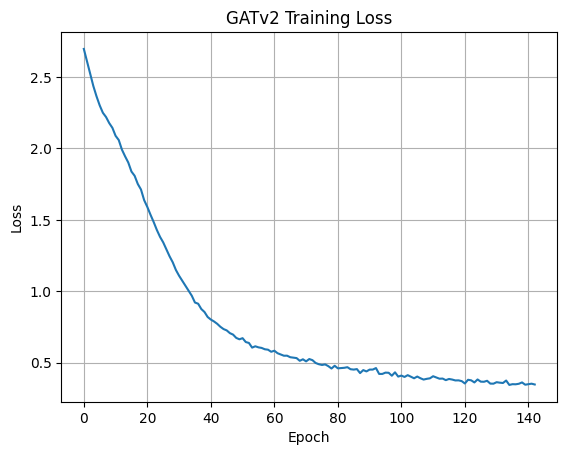

In [26]:
plt.plot(train_losses)
plt.title("GATv2 Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()


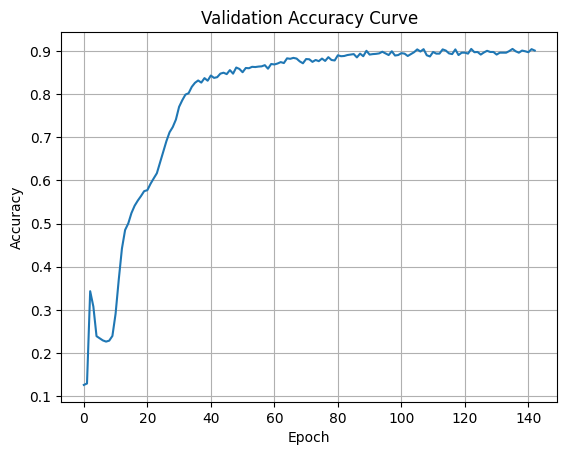

In [27]:
plt.plot(val_accs)
plt.title("Validation Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()


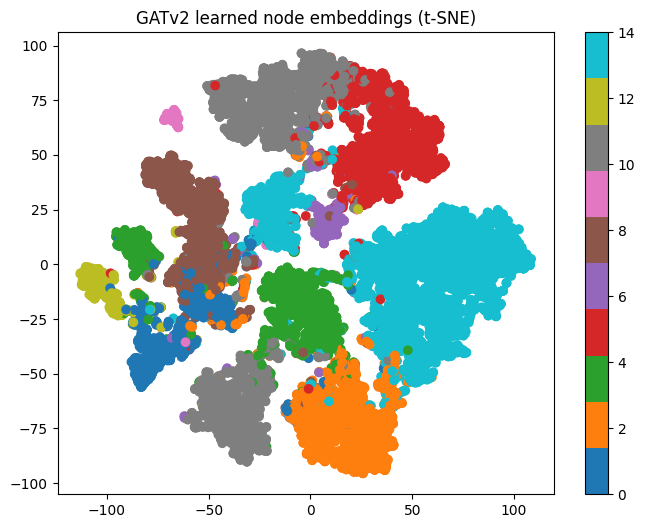

In [28]:
from sklearn.manifold import TSNE

model.eval()
emb = model(data.x, data.edge_index).detach().cpu().numpy()

tsne = TSNE(n_components=2, learning_rate='auto')
emb_2d = tsne.fit_transform(emb)

plt.figure(figsize=(8,6))
plt.scatter(emb_2d[:,0], emb_2d[:,1], c=data.y.cpu(), cmap="tab10")
plt.title("GATv2 learned node embeddings (t-SNE)")
plt.colorbar()
plt.show()
